In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

%matplotlib notebook

### Things to Resolve

1. Simplify the get_bass_model function
3. Visualize the extrapolated bass and the bass created from scratch
4. Perform simulated annealing method of finding start point.

### Q1

#### Helper functions

Discrete Bass Model

In [248]:
def get_bass_model(p, q, M, period = 30):
    
    A = [0] * period
    R = [0] * period
    F = [0] * period
    N = [0] * period
    
    A[0] = 0
    R[0] = M
    F[0] = p
    N[0] = M*p
    
    t = 1
    
    def get_bass_model_helper(A, R, F, N, t):
        
        if t == period:
            return N, F, R, A
        else:
            A[t] = N[t-1] + A[t-1]
            R[t] = M - A[t]
            F[t] = p + q * A[t]/M
            N[t] = F[t] * R[t]
            return get_bass_model_helper(A, R, F, N, t+1)
        
    N, F, R, A = get_bass_model_helper(A, R, F, N, t)
    return np.array(N), np.array(A)

Extrapolate Bass Model from given data

In [211]:
def extrapolate_bass(p, q, M, till_period,**kwargs):
    
    A = np.zeros(till_period)
    N = np.zeros(till_period)
    R = np.zeros(till_period)
    F = np.zeros(till_period)
    
    A[:len(kwargs['A'])] = kwargs['A']
    N[:len(kwargs['N'])] = kwargs['N']
    
    t = len(kwargs['A'])
        
    def extrapolate_bass_helper(A, R, F, N, t):
        
        if t == till_period:
            return N, F, R, A
        else:
            A[t] = N[t-1] + A[t-1]
            R[t] = M - A[t]
            F[t] = p + q * A[t]/M
            N[t] = F[t] * R[t]
            return extrapolate_bass_helper(A, R, F, N, t + 1)
    
    N, F, R, A = extrapolate_bass_helper(A, R, F, N, t)
    
    #to make sure N[t] corresponst to time period t
    return N, A   

Getting continuos bass model.

In [263]:
def get_cont_bass_model(p, q, M, period = 30):
    
    N = np.zeros(period)
    A = np.zeros(period) 
    
    for t in range(0, period):
        A_t = M * (1 - np.exp(- (p + q) * t)) / (1 + (q / p) * np.exp(- (p + q) * t))
        A_t_1 = M * (1 - np.exp(- (p + q) * (t - 1))) / (1 + (q / p) * np.exp(- (p + q) * (t - 1)))
    
        A[t] = A_t
        N[t] = A_t - A_t_1
        
    return N, A

#### 1

In [182]:
data = pd.read_excel('data/adoptionseries2_with_noise.xlsx')

Running the regression.

$$ A(t) = N(t-1) + A(t-1) $$
$$ A(1) = 0 $$

For example,
$$ A(2) = N(1) + A(1) = N(1) $$
$$ A(3) = N(2) + A(2) = N(2) + A(1) $$

Formulating A

In [183]:
data['A(t)'] = pd.Series(np.insert(data['N(t)'].values, 0, 0).cumsum())

Performing the regression

$$ intercept = Mp $$
$$ a = -\frac{q}{M} $$
$$ b = q - p $$
$$ c = Mp $$

In [185]:
data['A(t)_2'] = data['A(t)'] ** 2

X = data.iloc[:, 2:]
y = data.iloc[:, 1]

model = LinearRegression()
model = model.fit(X, y)

c = model.coef_[1]
b = model.coef_[0]
a = model.intercept_

p_pred = (np.sqrt(b**2 - 4*a*c) - b) / 2
q_pred = (np.sqrt(b**2 - 4*a*c) + b)/ 2
M_pred = -q_pred / c

N, A = extrapolate_bass(p_pred, q_pred, M_pred, till_period=30, N = data['N(t)'].values, A = data['A(t)'].values)

#N(30) corresponds to N[29], as indexing in python starts from 0.
print("p: {}\nq: {}\nM: {}\nN(30): {}".format(p_pred, q_pred, M_pred, N[29]))

p: 0.0027924053944219235
q: 0.21409748324219813
M: 34.40472892567334
N(30): 0.973841475615863


#### 2 & 3

In [340]:
from scipy.optimize import curve_fit

Creating the A(t) column.

In [341]:
data = pd.read_excel('data/adoptionseries2_with_noise.xlsx')

data['A(t)'] = pd.Series(np.insert(data['N(t)'].values, 0, 0).cumsum())

Creating the optimizing function:

In [342]:
def discrete_bass_func(A_t, p, q):
    return 100*p + (q - p) * A_t + (-q / 100) * (A_t ** 2)

Fitting the curve and obtaining the parameters. Obtaining N(30).

In [343]:
popt, pconv = curve_fit(discrete_bass_func, data['A(t)'].values, data['N(t)'].values, p0 = [0.02, 0.5])
p_pred, q_pred = popt
M = 100

N, A = extrapolate_bass(p_pred, q_pred, M, till_period=30, N = data['N(t)'].values, A = data['A(t)'].values)

#N(30) corresponds to N[29], as indexing in python starts from 0.
print("p: {}\nq: {}\nN(30): {}".format(p_pred, q_pred, N[29]))

p: 0.0010607266764848325
q: 0.19368439635584184
N(30): 4.890439591951741


#### 4

Importing and creating data.

In [427]:
data = pd.read_excel('data/adoptionseries2_with_noise.xlsx')

data['A(t)'] = pd.Series(np.insert(data['N(t)'].values, 0, 0).cumsum())

Creating the continuous bass model for the optimizer.

In [402]:
def continuos_bass_func(t, p, q):
    M = 100
    A_t = M * (1 - np.exp(- (p + q) * t)) / (1 + (q / p) * np.exp(- (p + q) * t))
    
    return A_t

Fitting the optimizer.

In [403]:
popt, pconv = curve_fit(continuos_bass_func, data['t'].values, data['A(t)'].values, bounds = (0., [1., 1.]))
p_pred, q_pred = popt

N_30 = continuos_bass_func(30, p_pred, q_pred) - continuos_bass_func(29, p_pred, q_pred)

print("p: {}\nq: {}\nN(30): {}".format(p_pred, q_pred, N_30))

p: 0.0006770352638220134
q: 0.19487406305521315
N(30): 4.888050512482138


##### Optimizing N(t) instead of A(t). Gives correct results.

In [428]:
def continuos_bass_func(t, p, q):
    
    M = 100
    
    A_t = M * (1 - np.exp(- (p + q) * t)) / (1 + (q / p) * np.exp(- (p + q) * t))
    A_t_1 = M * (1 - np.exp(- (p + q) * (t - 1))) / (1 + (q / p) * np.exp(- (p + q) * (t - 1)))
    
    return A_t - A_t_1

In [434]:
popt, pconv = curve_fit(continuos_bass_func, data['t'].values, data['N(t)'].values, bounds = (0., [1., 1.]),
                       p0 = [.02, 0.5])
p_pred, q_pred = popt
print(p_pred, q_pred)
continuos_bass_func(29, p_pred, q_pred)

0.0009554497080371496 0.17857012521625507


4.49451769814295

##### Optimize using sum of squares?

### Q2

In [435]:
fig, axs = plt.subplots(1, 1, figsize = (12, 15), sharex=True)

params = {
    'p': [0.05, 0.04, 0.06, 0.1, 0.09, 0.101],
    'q': [0.05, 0.06, 0.04, 0.1, 0.101, 0.09]
}


i = 0
period = 30
for parameter in list(zip(*params.values())):
    p, q = parameter

    t = list(range(1, period+1))
    
    N, A = get_bass_model(p, q, M = 100, period=period)
        
    axs[i][0].plot(t, N, 'o', markersize = 4)
    axs[i][0].set_ylim(0, 11)
    
    axs[i][0].spines['top'].set_visible(False)
    axs[i][0].spines['right'].set_visible(False)
    axs[i][0].set_title('Adoption Count for p = {} and q = {}'.format(p, q))
    axs[i][0].set_ylabel("New Customers")
    
    axs[i][1].plot(t, np.cumsum(N), 'o', markersize = 4)
    axs[i][1].set_ylim(0, 110)
    
    axs[i][1].spines['top'].set_visible(False)
    axs[i][1].spines['right'].set_visible(False)
    axs[i][1].set_title('Cumulative Adoption Count for p = {} and q = {}'.format(p, q))
    axs[i][1].set_ylabel("Total Customer Count")
    
    i = i + 1

fig.text(0.5, 0.001, 'Time (t)', ha='center', fontsize = 'large')
fig.tight_layout()


fig.savefig('Q2', dpi = 300)

<IPython.core.display.Javascript object>

TypeError: 'AxesSubplot' object is not subscriptable

### Q3

Estimation error of M is larger in the slide 13/14 than in the slide 15/16, and consequently the forecasted curve beyond period 15 is much further from the true curve in the first case than in the second case.  What differences in the two time series or the nature of the noise (up to period 15) lead the difference  described in the previous sentence?

Use different values of p, q to find out.

In [122]:
from scipy.optimize import curve_fit

def discrete_bass_func(A_t, p, q, M):
    return M*p + (q - p) * A_t + (-q / M) * (A_t ** 2)

period = 50
N, A = get_bass_model(p = 0.01, q = 0.5, M = 100, period = period)

Creating a noisy bass model.

In [123]:
N_noise = np.array([np.random.normal(0.05*n, 0.015*n, 1)[0] for n in t])

t = list(range(1, period))
N_noise = N_noise + N
data = pd.DataFrame({'t':t, 
                     'A(t)': A,
                     'A(t)_2': A ** 2,
                     'N(t)': N_noise}
            ,index = None)
data['A(t)_2'] = data['A(t)'] ** 2
data['A(t)'] = pd.Series(np.insert(data['N(t)'].values, 0, 0).cumsum())

popt, pconv = curve_fit(discrete_bass_func, data['A(t)'].values, data['N(t)'].values, bounds = (0., [1.,1., 1000]))
p_pred, q_pred, M_pred = popt
print(popt)

N_new, A_new = get_bass_model(p = p_pred, q = q_pred, M = M_pred, period = period)

[3.55344591e-02 7.59579762e-02 1.50107412e+02]


Plotting the differences.

<IPython.core.display.Javascript object>


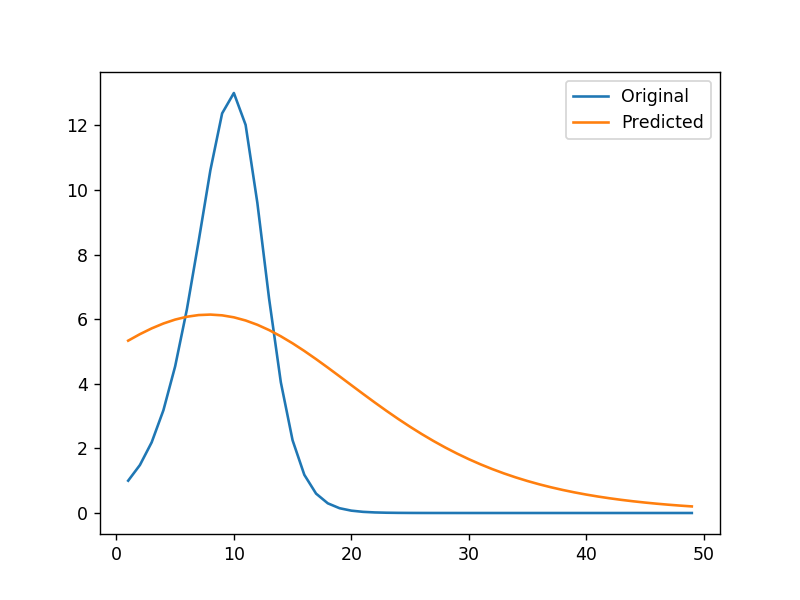

In [124]:
plt.figure()
plt.plot(t, N, label = "Original")
plt.plot(t, N_new, label = "Predicted")
plt.legend()

##### A function might come in handy.

In [144]:
def compare_noise(p, q, M, ax, time_varied_noise = False, noise_std  = 0.005):
    def discrete_bass_func(A_t, p, q, M):
        return M*p + (q - p) * A_t + (-q / M) * (A_t ** 2)

    period = 50
    t = list(range(1, period))
    
    N, A = get_bass_model(p = 0.01, q = 0.5, M = 100, period = period)
    
    if time_varied_noise:
        N_noise = np.array([np.random.normal(0.05*n, noise_std*n, 1)[0] for n in t])
        N_noise = N_noise + N
    else:
        N_noise = np.array([np.random.normal(n, noise_std*n, 1)[0] for n in N])
    
    data = pd.DataFrame({'t':t, 
                         'A(t)': A,
                         'A(t)_2': A ** 2,
                         'N(t)': N_noise}
                ,index = None)
    data['A(t)_2'] = data['A(t)'] ** 2
    data['A(t)'] = pd.Series(np.insert(data['N(t)'].values, 0, 0).cumsum())

    popt, pconv = curve_fit(discrete_bass_func, data['A(t)'].values, data['N(t)'].values, bounds = (0., [1.,1., 1000]))
    p_pred, q_pred, M_pred = popt
    print(popt)

    N_new, A_new = get_bass_model(p = p_pred, q = q_pred, M = M_pred, period = period)
    
    ax.plot(t, N, label = "Original")
    ax.plot(t, N_new, label = "Predicted")
    ax.legend()

#### In the first case, the noise increases with time, while in the second case, it remains more or less constant.

<IPython.core.display.Javascript object>


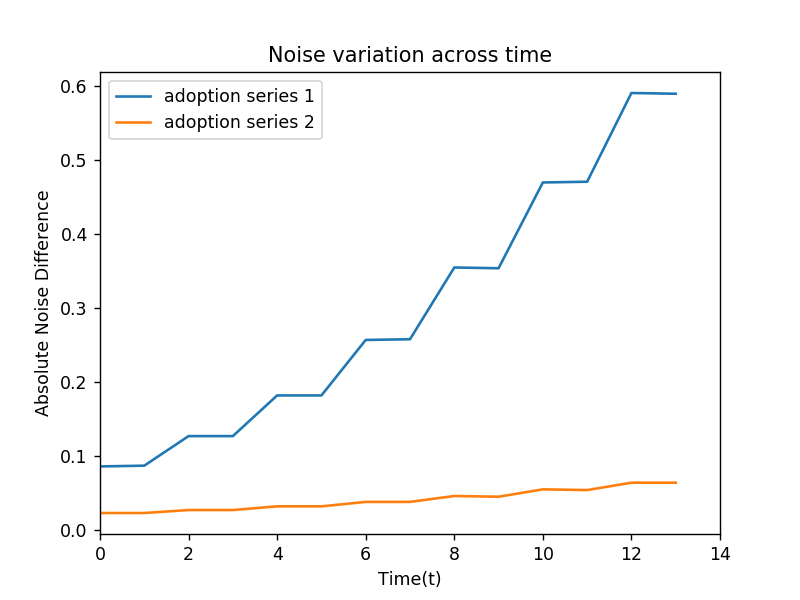

In [223]:
plt.figure()

df_1 = pd.read_excel('data/adoptionseries1.xlsx')
noise_1 = pd.read_excel('data/adoptionseries1_with_noise.xlsx')

#adoption1 = df_1.join(noise_1.set_index('t'), on = 't', lsuffix = '', rsuffix = '_noise')
np.abs(df_1['N(t)'] - noise_1['N(t)']).plot(label = "adoption series 1")

df_2 = pd.read_excel('data/adoptionseries2.xlsx')
noise_2 = pd.read_excel('data/adoptionseries2_with_noise.xlsx')

np.abs(df_2['N(t)'] - noise_2['N(t)']).plot(label = "adoption series 2")

plt.title("Noise variation across time")
plt.legend()
plt.gca().set_xlabel("Time(t)")
plt.gca().set_ylabel("Absolute Noise Difference")

plt.gcf().savefig('Q3_1.png', dpi = 500)

#### Exploring various ranges of p , q

##### When the noise is NOT Time varied

###### Low q

<IPython.core.display.Javascript object>


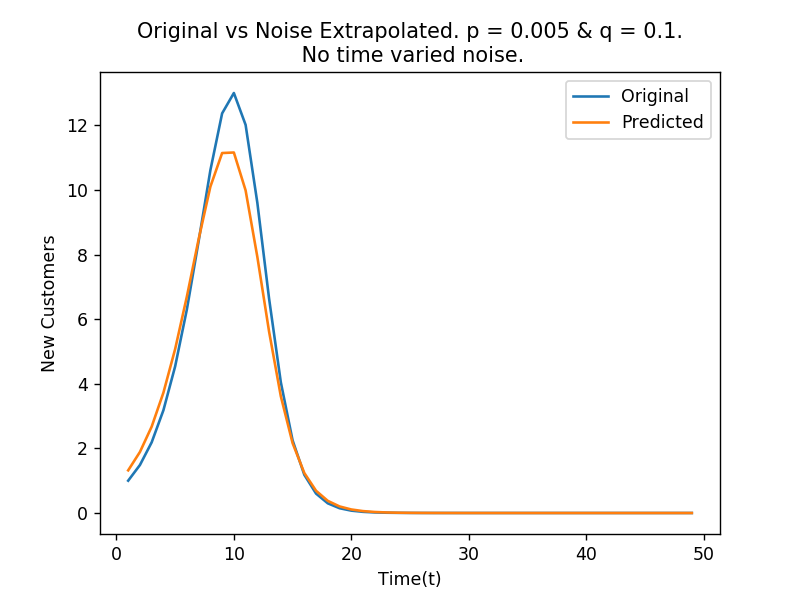

[1.40001341e-02 4.50821163e-01 9.42942712e+01]


In [236]:
plt.figure()
ax = plt.gca()

p = 0.005
q = 0.1

compare_noise(p, q, 100, ax, time_varied_noise = False, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}.\n No time varied noise.".format(p, q))

ax.set_xlabel("Time(t)")
ax.set_ylabel("New Customers")

plt.gcf().savefig("Q3-nt.png", dpi = 500)

###### Normal q

<IPython.core.display.Javascript object>


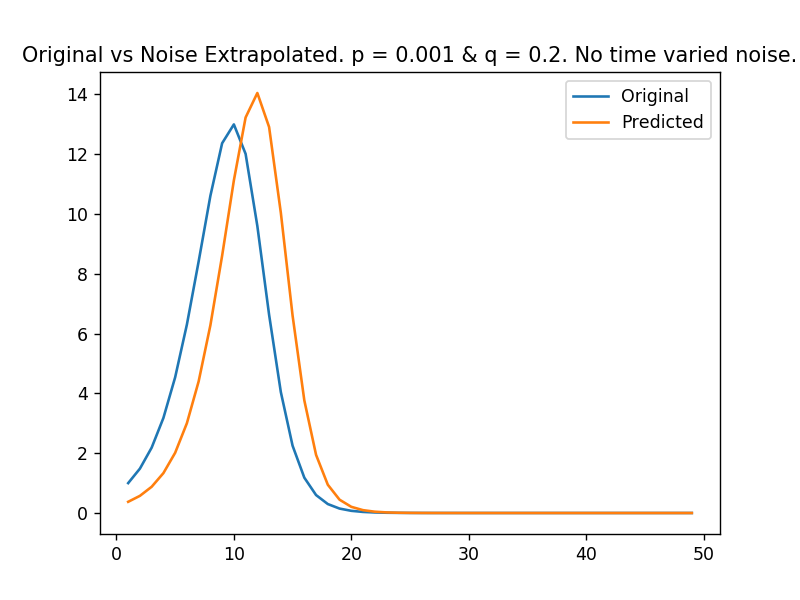

[3.63885699e-03 5.38854126e-01 1.02916928e+02]


Text(0.5, 1.0, 'Original vs Noise Extrapolated. p = 0.001 & q = 0.2. No time varied noise.')

In [160]:
plt.figure()
ax = plt.gca()

p = 0.001
q = 0.2

compare_noise(p, q, 100, ax, time_varied_noise = False, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}. No time varied noise.".format(p, q))

###### Higher q

<IPython.core.display.Javascript object>


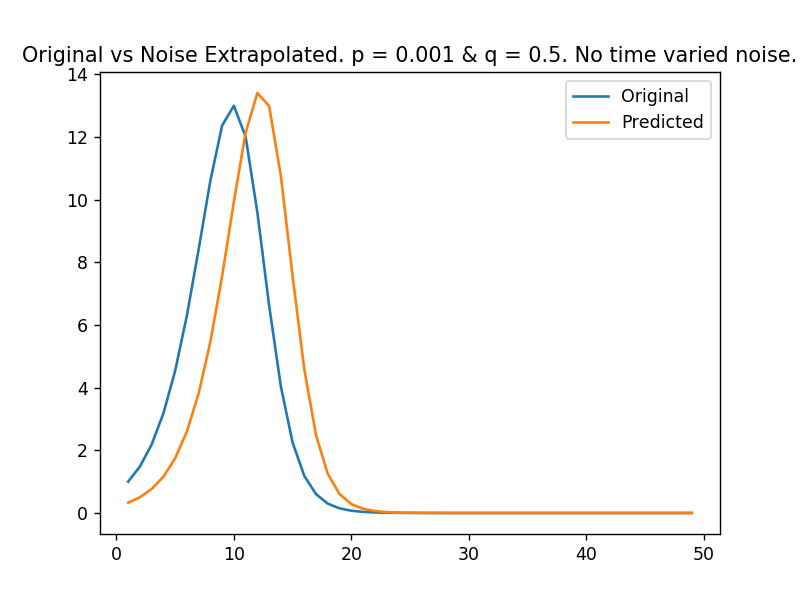

[3.28664112e-03 5.31601685e-01 1.00199242e+02]


Text(0.5, 1.0, 'Original vs Noise Extrapolated. p = 0.001 & q = 0.5. No time varied noise.')

In [161]:
plt.figure()
ax = plt.gca()

p = 0.001
q = 0.5

compare_noise(p, q, 100, ax, time_varied_noise = False, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}. No time varied noise.".format(p, q))

###### Low P

<IPython.core.display.Javascript object>


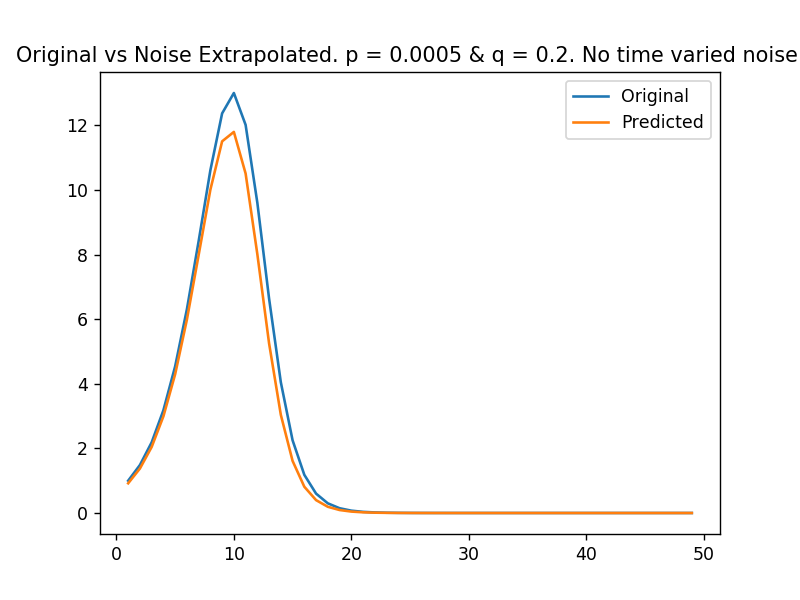

[1.03426877e-02 5.13104247e-01 8.88962333e+01]


Text(0.5, 1.0, 'Original vs Noise Extrapolated. p = 0.0005 & q = 0.2. No time varied noise.')

In [162]:
plt.figure()
ax = plt.gca()

p = 0.0005
q = 0.2

compare_noise(p, q, 100, ax, time_varied_noise = False, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}. No time varied noise.".format(p, q))

###### High P

<IPython.core.display.Javascript object>


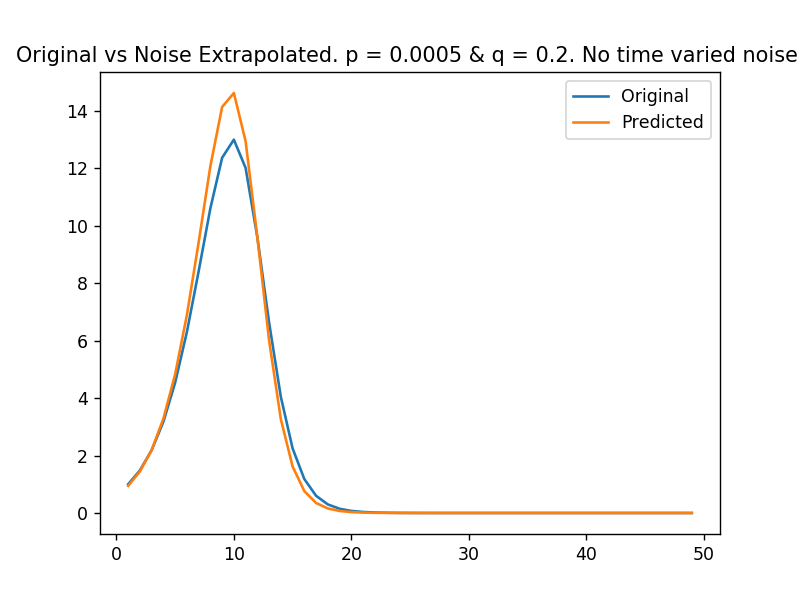

[9.03408504e-03 5.43183249e-01 1.04708455e+02]


Text(0.5, 1.0, 'Original vs Noise Extrapolated. p = 0.0005 & q = 0.2. No time varied noise.')

In [164]:
plt.figure()
ax = plt.gca()

p = 0.0005
q = 0.2

compare_noise(p, q, 100, ax, time_varied_noise = False, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}. No time varied noise.".format(p, q))

##### Time Varied Noise

###### Low q

<IPython.core.display.Javascript object>


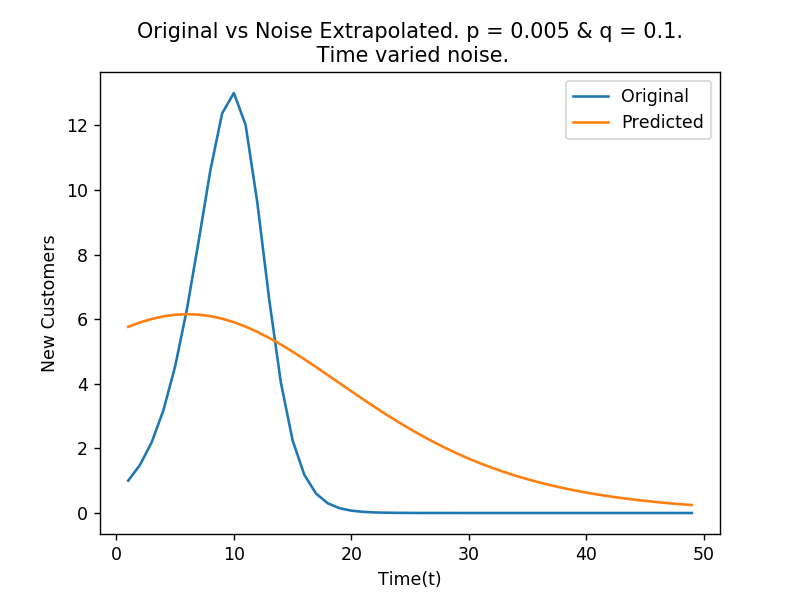

[3.84311030e-02 6.43954843e-02 1.49918279e+02]


In [235]:
plt.figure()
ax = plt.gca()

p = 0.005
q = 0.1

compare_noise(p, q, 100, ax, time_varied_noise = True, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}.\n Time varied noise.".format(p, q))

ax.set_xlabel("Time(t)")
ax.set_ylabel("New Customers")

plt.gcf().savefig("Q3-t.png", dpi = 500)

###### Medium q

<IPython.core.display.Javascript object>


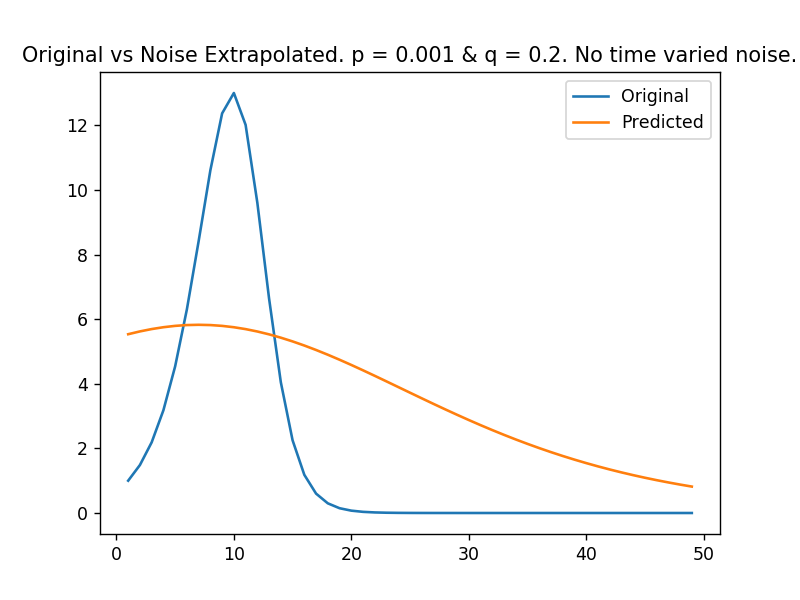

[2.95745235e-02 4.66280674e-02 1.87100932e+02]


Text(0.5, 1.0, 'Original vs Noise Extrapolated. p = 0.001 & q = 0.2. No time varied noise.')

In [175]:
plt.figure()
ax = plt.gca()

p = 0.001
q = 0.2

compare_noise(p, q, 100, ax, time_varied_noise = True, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}. No time varied noise.".format(p, q))

###### High q

<IPython.core.display.Javascript object>


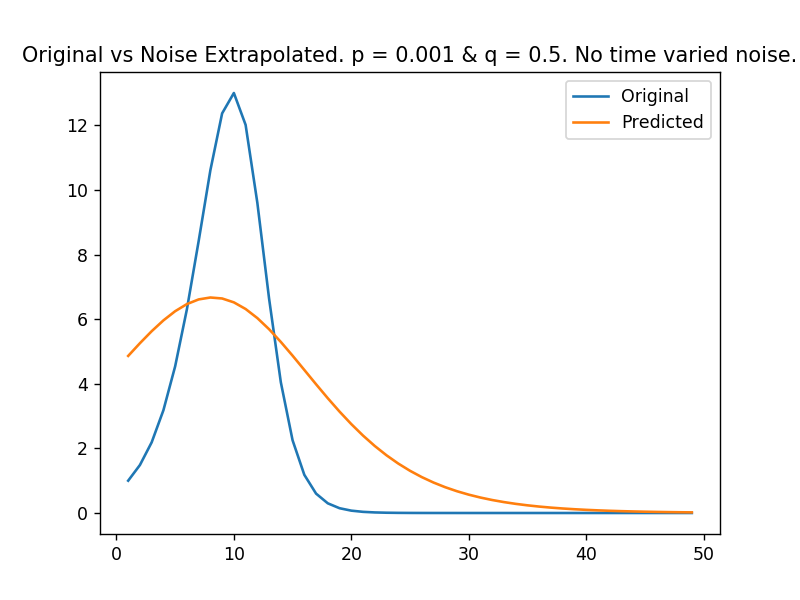

[3.95100773e-02 1.25385414e-01 1.23048263e+02]


Text(0.5, 1.0, 'Original vs Noise Extrapolated. p = 0.001 & q = 0.5. No time varied noise.')

In [177]:
plt.figure()
ax = plt.gca()

p = 0.001
q = 0.5

compare_noise(p, q, 100, ax, time_varied_noise = True, noise_std=0.3)
plt.title("Original vs Noise Extrapolated. p = {} & q = {}. No time varied noise.".format(p, q))

### Q4

In [337]:
p = 0.3
q = 0.2

M = 100

N_cont, A_cont = get_cont_bass_model(p, q, M, period= 50)
N_dis, A_dis = get_bass_model(p, q, M, period = 50)

print(N_cont[29])
print(N_dis[29])

5.453012752809627e-05
2.4515166026854844e-07


<IPython.core.display.Javascript object>


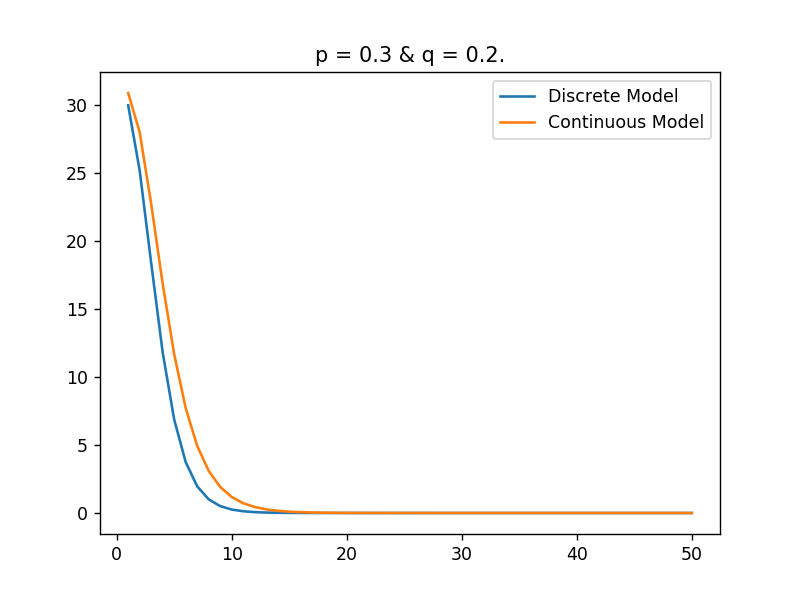

Text(0.5, 1.0, 'p = 0.3 & q = 0.2.')

In [338]:
plt.figure()

t = list(range(1, 50 + 1))

plt.plot(t, N_dis, label = "Discrete Model")
plt.plot(t, N_cont, label = "Continuous Model")
plt.legend()
plt.title("p = {} & q = {}.".format(p, q))

#plt.gcf().savefig('Q4-2.png', dpi = 500)

### Q5

#### Simulated Annealing

In [459]:
from scipy.optimize import dual_annealing

data = pd.read_excel('Code/data/adoptionseries2_with_noise.xlsx')
data['A(t)'] = pd.Series(np.insert(data['N(t)'].values, 0, 0).cumsum())

def discrete_bass_func(A_t, p, q):
    return 100*p + (q - p) * A_t + (-q / 100) * (A_t ** 2)

#dual_annealing(discrete_bass_func, bounds = [(0, 1), (0, 1)], args = data['A(t)'])


#### Multiple-Start Approach

In [430]:
size = 100

data = pd.read_excel('data/adoptionseries2_with_noise.xlsx')
data['A(t)'] = pd.Series(np.insert(data['N(t)'].values, 0, 0).cumsum())

p = np.random.random_sample(size)

q = np.random.random_sample(size)

p_pred = np.zeros(size)
q_pred = np.zeros(size)

min_sq = 10
min_pq = (0, 0)
for p, q in list(zip(p, q)):
    popt, _ = curve_fit(discrete_bass_func, data['A(t)'], data['N(t)'], p0 = [p, q])
    
    p, q = popt
    N, A = get_bass_model(p, q, 100, period = data.shape[0])
    
    if sum((N - data['N(t)'])**2) < min_sq:
        min_sq = sum((N - data['N(t)'])**2)
        min_pq = p, q
    p_pred = p_pred + [p]
    q_pred = q_pred + [q]
    
np.unique(p_pred.round(decimals=50))

array([0.10607267])

In [431]:
print(min_pq)

(0.0010607266672119397, 0.1936843966012831)


### Medium Blog

<IPython.core.display.Javascript object>


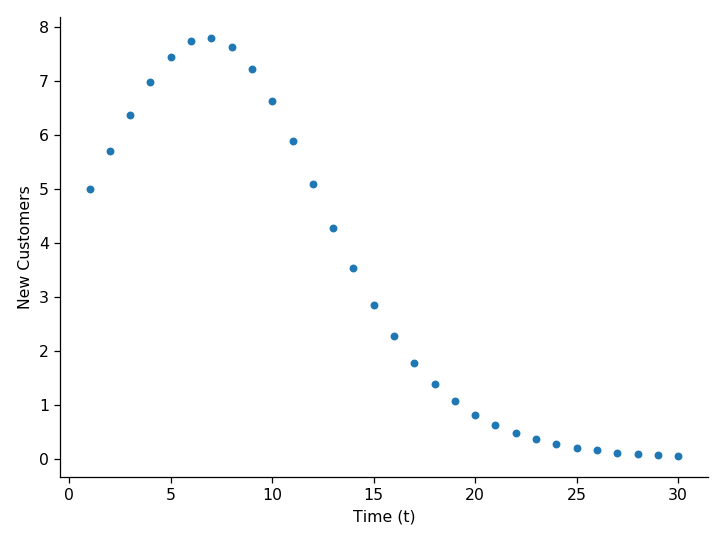

In [455]:
import sys
from discrete_bass_model import *

fig = plt.figure()
ax = plt.gca()

# Passing in the arguments from command line
p = sys.argv[0]
q = sys.argv[1]
M = sys.argv[2]
period = sys.argv[3]

N, A = get_bass_model(p, q, M = M, period=period)

# Plotting the data. Changing size of points.
ax.plot(t, N, 'o', markersize = 4)

# Give a more cleaner look
# Removing the top and right spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Setting label and title
ax.set_title('Adoption Count for p = {} and q = {}'.format(p, q))
ax.set_ylabel("New Customers")
ax.set_xlabel("Time (t)")

# Creating a clean layout
# Comment out plt.show() if you don't want a window to open
fig.tight_layout()
plt.show()

# saving image. Increase dpi for higher quality image
fig.savefig('bass-model', dpi = 500)